In [1]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Prepare Dataset
# load data

# relative path to npz files
path = 'Measurements/manual single top deformed at 20Hz'
file_name = 'output_batch_%d.npz'

def load_file(path, batch_id):
    """
    Loads in the memory a specific batch located in the given path.

    Returns a numpy NpzFile object with the image frames np array named
    as "frames" and the force measurements named as "frames".
    """
    combined_path = os.path.join(path,file_name %i)
    data = np.load(combined_path)
    return data

In [3]:
# Get dataset statistics for normalization
file_size = 1000 # one file contains 1000 samples
files_num = 2 # how many files to load
batch_size = 100 # should be something that leaves zero reminder when it divides the file_size
data_frames = []
data_forces = []
for i in range(files_num):
    data = load_file(path, i)
    data_frames.append(data['frames'])
    data_forces.append(data['forces'])
combined_frames = np.concatenate(data_frames, axis=0)
combined_forces = np.concatenate(data_forces, axis=0)
features_train = combined_frames
targets_train = combined_forces[:,2]
frames_mean = np.mean(features_train)
frames_std = np.std(features_train)
forces_z_mean = np.mean(targets_train)
forces_z_std = np.std(targets_train)
print(frames_mean)
print(frames_std)
print(forces_z_mean)
print(forces_z_std)

175.93011425797326
83.80256105196054
-0.986235911609605
1.4660020523737218


In [4]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_channels, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 9, kernel_size = 5, stride = 1, padding = 2)
        self.pool = nn.MaxPool2d(kernel_size = 4, stride = 4)
        self.conv2 = nn.Conv2d(9, 18, kernel_size = 5, stride = 1, padding = 2)
        
        # RNN
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(18 * 16 * 30, hidden_dim, layer_dim, batch_first=True, dropout = 0.2, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Convolutional layers
        x = self.pool(nn.ELU()(self.conv1(x)))
        x = self.pool(nn.ELU()(self.conv2(x)))
        
        # Reshape for RNN
        # x = torch.reshape(x, (100, 10, 18 * 16 * 30))
        x = torch.reshape(x, (4, 25, 18 * 16 * 30))  # Reshape to (batch_size, seq_len, input_size)
        #print("Size of x:", x.size())  # Print size of x
        
        # RNN
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        #print("Size of h0:", h0.size())  # Print size of h0 - Debugging - Obsolete
        out, hn = self.rnn(x, h0)
        
        # Output layer
        out = self.fc(out) 
        # out = torch.reshape(out, (1000, 1))
        out = torch.reshape(out, (100, 1)) # go back to compare to labels
        return out

In [5]:
# Create RNN
input_channels = 3  # RGB channels
hidden_dim = 200  # hidden layer dimension
layer_dim = 2     # number of hidden layers
output_dim = 1   # output dimension

model = RNNModel(input_channels, hidden_dim, layer_dim, output_dim)

# Define your loss function
error = nn.MSELoss()

# Define your optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# Training

file_size = 1000 # one file contains 1000 samples
num_epochs = 20
files_num = 2 # how many files to load
seq_dim = 25
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
batch_size = 100 # should be something that leaves zero reminder when it divides the file_size
last_iter = -files_num * file_size/batch_size
for epoch in range(num_epochs):
    for i in range(files_num):
        data = load_file(path, i)
        
        for i in range(int(file_size/batch_size)):
            # Normalize
            normalized_frames = (data['frames'][i*batch_size:(i+1)*batch_size,:,:,:]-frames_mean)/frames_std
            normalized_forces = (data['forces'][i*batch_size:(i+1)*batch_size,2]-forces_z_mean)/forces_z_std

            # Create tensors
            images = torch.from_numpy(normalized_frames).float()
            labels = torch.from_numpy(normalized_forces).float()
                    
            # print(images.shape)  # Add this line to check the shape of images - Debugging purposes
            images = images.permute(0, 3, 1, 2)
                
            # Clear gradients
            optimizer.zero_grad()
            
            # Forward propagation
            outputs = model(images)
            outputs = torch.squeeze(outputs)
            
            # Calculate loss
            loss = error(outputs, labels)
            
            # Backpropagation
            loss.backward()
            
            # Update parameters
            optimizer.step()
            
            count += 1
                
            # Store loss and iteration
            loss_rescaled = loss.data.item() * pow(forces_z_std, 2)
            loss_list.append(loss_rescaled)
    # Print Loss
    print('Epoch: {}, MSE Loss: {}'.format((epoch+1), np.mean(loss_list[int(last_iter):])))

Epoch: 1, MSE Loss: 1.9183302570890892
Epoch: 2, MSE Loss: 1.1880047284587913
Epoch: 3, MSE Loss: 0.6568353226870375
Epoch: 4, MSE Loss: 0.5117723666211221
Epoch: 5, MSE Loss: 0.3863108565355913
Epoch: 6, MSE Loss: 0.2943053015900254
Epoch: 7, MSE Loss: 0.22773957766134423
Epoch: 8, MSE Loss: 0.19261783243696257
Epoch: 9, MSE Loss: 0.1706789374459088
Epoch: 10, MSE Loss: 0.14659437761638297
Epoch: 11, MSE Loss: 0.13431284646042424
Epoch: 12, MSE Loss: 0.11905128527568558
Epoch: 13, MSE Loss: 0.11273544377367153
Epoch: 14, MSE Loss: 0.10098046802662344
Epoch: 15, MSE Loss: 0.1022652841927405
Epoch: 16, MSE Loss: 0.09528391895569863
Epoch: 17, MSE Loss: 0.08976346460442816
Epoch: 18, MSE Loss: 0.08208669549772472
Epoch: 19, MSE Loss: 0.08240787231799578
Epoch: 20, MSE Loss: 0.07021672124358316


[3.4525863155413057, 1.9982700357706207, 2.1856351729604784, 2.249834044516188, 1.4157837881532893, 1.2305752151136269, 0.9224313408094509, 2.3693406201469545, 2.042833605306363, 1.8730431529152038, 1.7322943883800006, 1.997339517090073, 1.8000535443091217, 1.7510292752284957, 1.692730050951507, 2.099621889627809, 1.607213667668651, 1.2386720342547863, 2.3443060295991227, 2.363011453438735, 2.471127629835341, 1.2544809881211243, 1.3978363322422014, 1.3072797248397374, 1.118756435200701, 0.8566117475651003, 0.6006529467445203, 1.5962776392714813, 1.3164208154957406, 1.2519549834595436, 1.0340123030006758, 1.190798744021176, 1.041055307174114, 0.9042714950343282, 0.8872892729142545, 1.3196271594624407, 0.926921631463256, 0.7338629599568197, 1.3208570479332473, 1.2299994054400225, 1.5413635866151085, 0.6081855492655706, 0.5752007500707823, 0.4650088086233418, 0.6515688690954723, 0.42721593460393775, 0.33645753761563507, 0.6813920312370393, 0.6617624937188104, 0.7345776300722899, 0.6254251

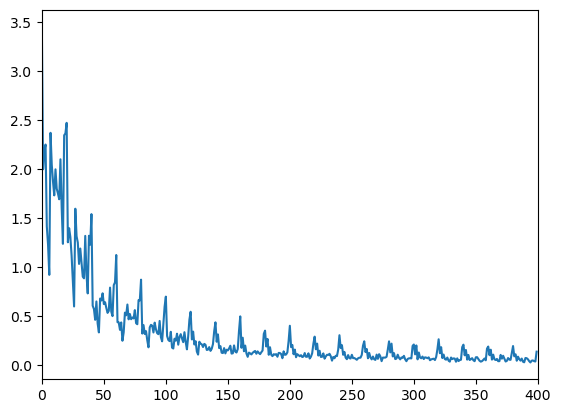

In [7]:
print(loss_list)
print(np.sqrt(np.mean(loss_list[-20:])))
plt.plot(range(len(loss_list)), loss_list)
plt.xlim((0,400))
plt.show()

In [8]:
print(outputs * forces_z_std + forces_z_mean) # Small sanity check

tensor([-2.7230, -1.6543, -0.9111, -0.7833, -0.4040, -0.6730, -0.3296, -0.1528,
        -0.1008, -0.3290, -0.1976,  0.0195, -0.2337, -0.0888, -0.2400, -0.1912,
        -0.0659, -0.0848, -0.3024, -0.1065, -0.1952, -0.2750, -0.0833, -0.2586,
        -0.0346, -0.1972, -0.0162, -0.0447, -0.1236, -0.0413, -0.7484, -1.2373,
        -2.8738, -3.3266, -3.3581, -3.8808, -3.8396, -4.1315, -4.4004, -4.4873,
        -4.6109, -4.8436, -4.9909, -4.3417, -3.0203, -1.8334, -0.4245, -0.1036,
        -0.4243, -0.2069, -1.2642, -0.8248, -0.6820, -0.5224, -0.4440, -0.6930,
        -0.4704, -0.3083, -0.1208, -0.1512, -0.2163, -0.4942, -0.2274, -0.3196,
        -0.2415, -0.1731, -0.1270, -0.2295, -0.4229, -0.1327, -0.4122, -0.4921,
        -0.9207, -1.4397, -2.4066, -2.5190, -3.1945, -3.7159, -3.8796, -4.4225,
        -4.0853, -4.8200, -4.8567, -4.1571, -4.3582, -3.5499, -2.5769, -0.8757,
        -0.1837, -0.3022, -0.2161, -0.1924, -0.4619, -0.5548, -0.4564, -0.1234,
        -0.3216, -0.2846, -0.0339, -0.21

In [9]:
print(labels.float() * forces_z_std + forces_z_mean)

tensor([-0.9837, -0.1637, -0.1279, -0.1309, -0.1346, -0.1297, -0.1344, -0.1294,
        -0.1343, -0.1282, -0.1322, -0.1240, -0.1298, -0.1313, -0.1317, -0.1270,
        -0.1292, -0.1361, -0.1341, -0.1336, -0.1390, -0.1233, -0.1278, -0.1282,
        -0.1346, -0.1320, -0.1334, -0.1283, -0.1324, -0.3513, -1.0552, -1.5855,
        -2.5075, -2.8629, -3.2809, -3.5987, -4.0110, -4.4015, -4.5454, -4.9288,
        -5.1063, -5.1722, -4.9448, -4.5689, -3.3009, -1.5864, -0.2401, -0.1187,
        -0.1239, -0.1288, -0.1313, -0.1257, -0.1342, -0.1297, -0.1307, -0.1230,
        -0.1293, -0.1233, -0.1307, -0.1248, -0.1389, -0.1326, -0.1363, -0.1292,
        -0.1340, -0.1309, -0.1326, -0.1288, -0.1315, -0.1237, -0.1371, -0.3839,
        -0.8983, -1.3171, -2.2785, -2.7973, -3.4132, -3.8083, -4.2586, -4.6140,
        -4.6368, -4.7420, -4.7785, -4.7576, -4.3578, -3.5074, -1.8832, -0.4341,
        -0.1187, -0.1313, -0.1282, -0.1306, -0.1325, -0.1369, -0.1345, -0.1265,
        -0.1310, -0.1315, -0.1313, -0.12

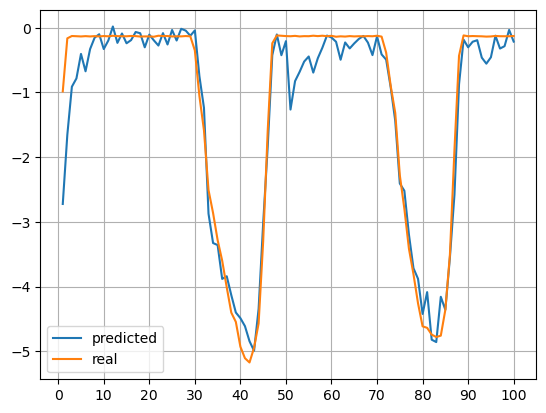

In [10]:
pred_forcess = outputs * forces_z_std + forces_z_mean
forcess = labels.float() * forces_z_std + forces_z_mean
pred_forcess = pred_forcess.detach().numpy()
forcess = forcess.detach().numpy()
plt.plot(range(1,len(pred_forcess)+1), pred_forcess, label = "predicted")
plt.plot(range(1,len(forcess)+1), forcess, label = "real")
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.grid()
plt.legend()
plt.show()